In [1]:
import tensorflow as tf
import math
print("TensorFlow version:", tf.__version__)
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Activation, Input, BatchNormalization
from tensorflow.keras import Model
from tensorflow.keras.preprocessing import image_dataset_from_directory

TensorFlow version: 2.9.2


In [2]:
def FCN_model(len_classes=3, shape=(227, 227, 1), dropout_rate=0.2):
    model = tf.keras.models.Sequential(name='fcn')
    model.add(BatchNormalization(input_shape=(227, 227, 1)))
    model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding="valid"))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same'))

    model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=1))
    # model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same'))

    model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=2))
    # model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same'))

    model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=2))
    # model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))

    model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=2))
    model.add(tf.keras.layers.Dropout(dropout_rate))
    # model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))

    model.add(tf.keras.layers.Conv2D(filters=math.ceil(math.log(len_classes,2)), kernel_size=1, strides=1))
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.GlobalMaxPooling2D())
    model.add(tf.keras.layers.Activation('sigmoid'))

    print(model.summary())
    print(f'Total number of layers: {len(model.layers)}')

    return model


In [3]:
fcn0=FCN_model(len_classes=2)

Model: "fcn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 227, 227, 1)      4         
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 225, 225, 32)      320       
                                                                 
 batch_normalization_1 (Batc  (None, 225, 225, 32)     128       
 hNormalization)                                                 
                                                                 
 activation (Activation)     (None, 225, 225, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 113, 113, 32)     0         
 )                                                               
                                                               

In [4]:
train_dir="/notebooks/ultrasound/train"
validation_dir=train_dir
test_dir="/notebooks/ultrasound/val"
batch_size=64
test_train_split=0.3
train_data = image_dataset_from_directory(\
      train_dir,color_mode="grayscale",image_size=(227,227) ,\
      subset='training',seed=5, validation_split=test_train_split,\
      batch_size=batch_size)
validation_data = image_dataset_from_directory(validation_dir,
      color_mode="grayscale",image_size=(227,227), subset='validation',seed=5,\
      validation_split=test_train_split,batch_size=batch_size)
test_data = image_dataset_from_directory(test_dir,
      color_mode="grayscale",image_size=(227,227), batch_size=batch_size)

Found 8116 files belonging to 2 classes.
Using 5682 files for training.
Found 8116 files belonging to 2 classes.
Using 2434 files for validation.
Found 900 files belonging to 2 classes.


In [5]:
fcn0.compile(loss="BinaryCrossentropy", optimizer='Adam', metrics=["BinaryAccuracy"])

In [6]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [7]:
history = fcn0.fit(train_data,
            epochs=100,
            validation_data=validation_data,callbacks=[callback])

Epoch 1/100
89/89 [==============================] - 11s 77ms/step - loss: 0.6893 - binary_accuracy: 0.5658 - val_loss: 0.6767 - val_binary_accuracy: 0.5353
Epoch 2/100
89/89 [==============================] - 6s 70ms/step - loss: 0.6086 - binary_accuracy: 0.6698 - val_loss: 0.6394 - val_binary_accuracy: 0.6549
Epoch 3/100
89/89 [==============================] - 6s 70ms/step - loss: 0.5120 - binary_accuracy: 0.7749 - val_loss: 0.6094 - val_binary_accuracy: 0.8159
Epoch 4/100
89/89 [==============================] - 6s 70ms/step - loss: 0.4726 - binary_accuracy: 0.8089 - val_loss: 0.6272 - val_binary_accuracy: 0.6923
Epoch 5/100
89/89 [==============================] - 6s 70ms/step - loss: 0.4333 - binary_accuracy: 0.8397 - val_loss: 0.5478 - val_binary_accuracy: 0.8361
Epoch 6/100
89/89 [==============================] - 6s 72ms/step - loss: 0.3926 - binary_accuracy: 0.8610 - val_loss: 0.5088 - val_binary_accuracy: 0.8546
Epoch 7/100
89/89 [==============================] - 7s 72ms/st

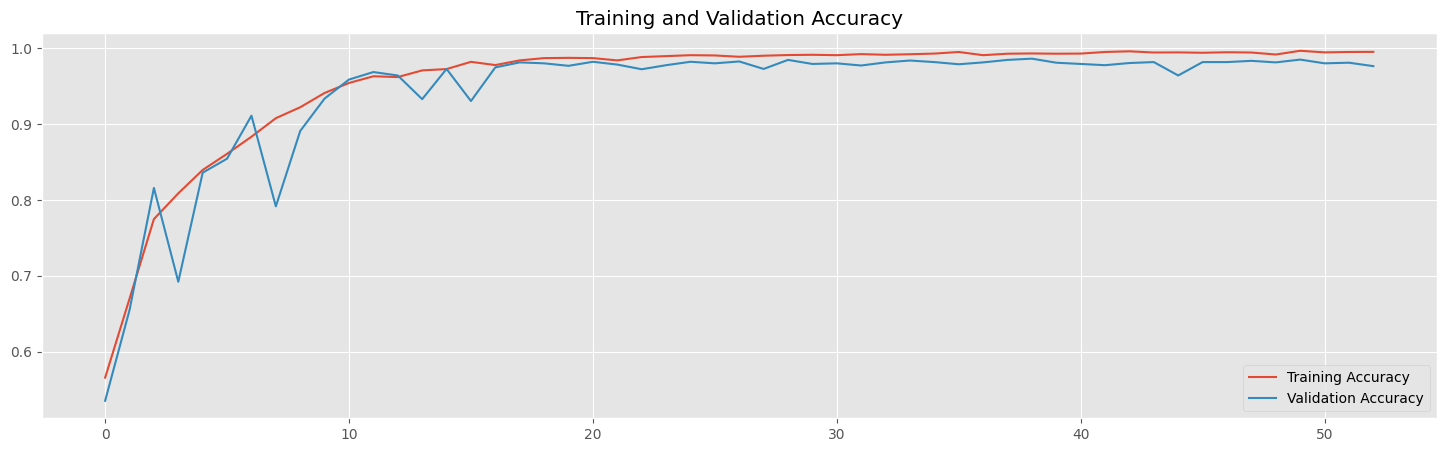

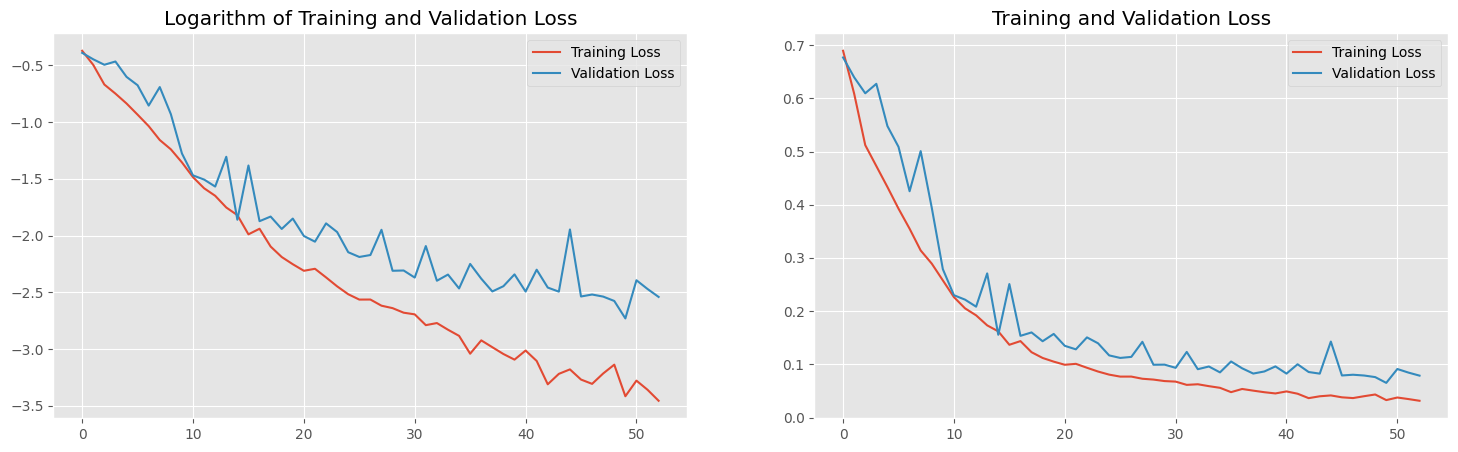

In [8]:
epochs_run=len(history.epoch)
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs_run)
plt.style.use('ggplot')
plt.figure(figsize=(18, 5))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.figure(figsize=(18, 5))
plt.subplot(1,2,1)
plt.plot(epochs_range, np.log(loss), label='Training Loss')
plt.plot(epochs_range, np.log(val_loss), label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Logarithm of Training and Validation Loss')

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

plt.show()

In [9]:
results = fcn0.evaluate(test_data, batch_size=128)
print("test loss, test acc:", results)

15/15 [==============================] - 0s 22ms/step - loss: 0.3499 - binary_accuracy: 0.8833
test loss, test acc: [0.34987279772758484, 0.8833333253860474]


In [10]:
fcn0.save('../models/fcn_0_ultrasound')

INFO:tensorflow:Assets written to: ../models/fcn_0_ultrasound/assets


INFO:tensorflow:Assets written to: ../models/fcn_0_ultrasound/assets
